In [13]:
import pandas as pd
import numpy as np
import os

# === 路徑（請視需要修改）===
file_t23 = r"D:\ArcGIS\Morpho_Spatial_Demography\data\K1a_T23SJT25.csv"
file_t25 = r"D:\ArcGIS\Morpho_Spatial_Demography\data\K1a_T25SJT23.csv"

# === 讀檔（以字串讀入較穩健）===
df_t23 = pd.read_csv(file_t23, dtype=str)
df_t25 = pd.read_csv(file_t25, dtype=str)

# --- 工具：清成穩定字串（去 .0、小數尾、nan/None 處理）---
def clean_str(v):
    if pd.isna(v) or v is None:
        return ""
    s = str(v).strip()
    if s.endswith(".0"):
        s = s[:-2]
    if "." in s:
        s = s.split(".")[0]
    if s.lower() in ("nan", "none"):
        return ""
    return s

# 清理 ID / Temp_ID / Form_ID
for df in (df_t23, df_t25):
    df["ID"] = df.get("ID", "").apply(clean_str) if "ID" in df.columns else ""
    df["Temp_ID"] = df.get("Temp_ID", "").apply(clean_str) if "Temp_ID" in df.columns else ""
    df["Form_ID"] = df.get("Form_ID", "").apply(clean_str) if "Form_ID" in df.columns else ""

# 數值欄位處理：T1/T2 的面積與周長
def ensure_numeric_column(df, col):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    else:
        df[col] = np.nan

# T1（第一年，存於 df_t23）
ensure_numeric_column(df_t23, "Shape_Area")
ensure_numeric_column(df_t23, "Shape_Length")
# T2（第二年，存於 df_t23 的 *_1 欄位）
ensure_numeric_column(df_t23, "Shape_Area_1")
ensure_numeric_column(df_t23, "Shape_Length_1")

# 也把 df_t25 的基本欄位 numeric（用於 Fu 判定的幾何不直接依賴，但保持一致性）
ensure_numeric_column(df_t25, "Shape_Area")
ensure_numeric_column(df_t25, "Shape_Length")

# === 建鍵（ID_key / Temp_key）以確保一致性 ===
df_t23["ID_key"] = df_t23["ID"].apply(clean_str)
df_t23["Temp_key"] = df_t23["Temp_ID"].apply(clean_str) if "Temp_ID" in df_t23.columns else ""
df_t25["ID_key"] = df_t25["ID"].apply(clean_str)
df_t25["Temp_key"] = df_t25["Temp_ID"].apply(clean_str) if "Temp_ID" in df_t25.columns else ""

# === 建 Form_ID 對照字典（清理後鍵）===
t1_form_map   = dict(zip(df_t23["ID_key"], df_t23.get("Form_ID", pd.Series([""]*len(df_t23))).apply(clean_str)))
id_form_map   = dict(zip(df_t25["ID_key"], df_t25.get("Form_ID", pd.Series([""]*len(df_t25))).apply(clean_str)))
temp_form_map = dict(zip(df_t25["Temp_key"], df_t25.get("Form_ID", pd.Series([""]*len(df_t25))).apply(clean_str)))

# === 找 Joint_count 欄位（容錯）===
jc_col = None
for c in df_t23.columns:
    if "joint" in c.lower():
        jc_col = c
        break

if jc_col is None:
    df_t23["Joint_Count"] = 0
    jc_col = "Joint_Count"
else:
    df_t23[jc_col] = pd.to_numeric(df_t23[jc_col], errors="coerce").fillna(0)

# === 準備輸出骨架：以 T23 的所有 ID (ID_key) 為基底 ===
unique_ids = pd.DataFrame({"T1_ID": df_t23["ID_key"].drop_duplicates().tolist()})

# === Step 1: Joint_info 與 Ramet（Fi/Death 粗判）===
joint_info = (
    df_t23.groupby("ID_key", as_index=False)[jc_col].max()
    .rename(columns={"ID_key": "T1_ID", jc_col: "Joint_Count"})
)

ramet_all = (
    df_t23.groupby("ID_key", as_index=False)["Temp_ID"]
       .apply(lambda s: "-".join(sorted(set(x for x in (clean_str(v) for v in s) if x))))
       .rename(columns={"ID_key": "T1_ID", "Temp_ID": "Ramet"})
)

merged = unique_ids.merge(joint_info, on="T1_ID", how="left").merge(ramet_all, on="T1_ID", how="left")

# 粗略標 Fate：Joint_Count == 0 -> Death, Joint_Count >1 -> Fi，其餘先留空
merged["Fate"] = np.select(
    [merged["Joint_Count"] == 0, merged["Joint_Count"] > 1],
    ["Death", "Fi"],
    default=""
)
merged["Ramet"] = np.where(merged["Fate"] == "Fi", merged["Ramet"].fillna(""), "")

# Fi 前置過濾：若 Ramet 的 Temp_ID 在 T25 的 Form_ID 不一致，取消 Fi
mask_fi = merged["Fate"] == "Fi"
for idx in merged.index[mask_fi]:
    ramet = merged.at[idx, "Ramet"] or ""
    parts = [clean_str(p) for p in ramet.split("-") if clean_str(p)]
    if not parts:
        merged.at[idx, "Fate"] = ""
        merged.at[idx, "Ramet"] = ""
        continue
    forms = {clean_str(temp_form_map.get(p, "")) for p in parts}
    if len(forms) != 1 or "" in forms:
        merged.at[idx, "Fate"] = ""

# === Step 2: Fusion (Fu) 與前置 Form_ID 檢查 ===
df_t23["Joint_count_num"] = df_t23[jc_col].fillna(0).astype(float)
t1_temp_map = (
    df_t23.loc[df_t23["Joint_count_num"] == 1, ["ID_key", "Temp_ID"]]
          .query("Temp_ID != ''")
          .drop_duplicates()
          .groupby("ID_key")["Temp_ID"]
          .first()
          .to_dict()
)

# 在 T25 找出 Temp_ID 對應多個不同 ID 的情形（候選 Fusion）
fuse_candidates = df_t25[df_t25["Temp_key"].isin(set(t1_temp_map.values()))].copy()
fuse_candidates["ID_str"] = fuse_candidates["ID_key"]

counts = fuse_candidates.groupby("Temp_key")["ID_str"].nunique().reset_index(name="ID_count")
fused_temp_ids = set(counts.loc[counts["ID_count"] > 1, "Temp_key"])

fusion_group_map = (
    fuse_candidates[fuse_candidates["Temp_key"].isin(fused_temp_ids)]
      .groupby("Temp_key")["ID_str"]
      .apply(lambda s: "+".join(sorted(set(s))))
      .to_dict()
)

# 檢查 fusion group 的 Form_ID 是否一致（前置過濾）
fusion_forms_ok = {}
for t in fused_temp_ids:
    ids_concat = fusion_group_map.get(t, "")
    parts = [clean_str(p) for p in ids_concat.split("+") if clean_str(p)]
    forms = {clean_str(id_form_map.get(p, "")) for p in parts}
    fusion_forms_ok[t] = (len(forms) == 1 and "" not in forms)

# 回填到 merged：符合 fusion_forms_ok 才標 Fu 並放 Fusion_Group
merged["Temp_ID"] = merged["T1_ID"].map(t1_temp_map).fillna("")
def maybe_fu(tempid, curfate):
    if tempid in fused_temp_ids and fusion_forms_ok.get(tempid, False):
        return "Fu"
    return curfate

merged["Fate"] = merged.apply(lambda r: maybe_fu(r["Temp_ID"], r["Fate"]), axis=1)
merged["Fusion_Group"] = merged["Temp_ID"].apply(lambda t: fusion_group_map.get(t, "") if fusion_forms_ok.get(t, False) else "")

# === Step 3: Growth (G) / Shrink (S)
# 依據你的規則：T1 來自 df_t23 的 Shape_Area，T2 來自 df_t23 的 Shape_Area_1
area_T1 = (
    df_t23.groupby("ID_key", as_index=False)["Shape_Area"]
          .sum()
          .rename(columns={"ID_key": "T1_ID", "Shape_Area": "A_T1"})
)
area_T2 = (
    df_t23.groupby("ID_key", as_index=False)["Shape_Area_1"]
          .sum()
          .rename(columns={"ID_key": "T1_ID", "Shape_Area_1": "A_T2"})
)

merged = merged.merge(area_T1, on="T1_ID", how="left").merge(area_T2, on="T1_ID", how="left")

eps = 1e-6
mask_to_compare = (merged["Fate"] == "") & (merged["Joint_Count"] == 1)
mask_other_unmarked = (merged["Fate"] == "") & (merged["Joint_Count"] != 1)

for idx in merged.index[mask_to_compare]:
    a1 = merged.at[idx, "A_T1"]
    a2 = merged.at[idx, "A_T2"]
    if pd.isna(a1) or pd.isna(a2):
        continue
    diff = float(a2) - float(a1)
    if diff > eps:
        merged.at[idx, "Fate"] = "G"
    elif diff < -eps:
        merged.at[idx, "Fate"] = "S"
    else:
        merged.at[idx, "Fate"] = "G"  # 近似持平歸 G（可依需求調整）

merged.loc[mask_other_unmarked, "Fate"] = "Check"
merged.loc[merged["Fate"] == "", "Fate"] = "Check"

# === Step 4: 合併 T1/T2 幾何資訊（T2 也從 df_t23 取得 *_1 欄位）
# T1 幾何（加總）
geom_T1 = (
    df_t23.groupby("ID_key", as_index=False)[["Shape_Length", "Shape_Area"]]
          .sum()
          .rename(columns={"ID_key": "T1_ID"})
)
# T2 幾何（加總，注意皆取自 df_t23 的 *_1 欄位）
length_T2 = (
    df_t23.groupby("ID_key", as_index=False)["Shape_Length_1"]
          .sum()
          .rename(columns={"ID_key": "T1_ID", "Shape_Length_1": "Shape_Length_T2"})
)
area_T2_for_output = (
    df_t23.groupby("ID_key", as_index=False)["Shape_Area_1"]
          .sum()
          .rename(columns={"ID_key": "T1_ID", "Shape_Area_1": "Shape_Area_T2"})
)

# Form 仍以第一年（df_t23）的第一筆為主
form_info = (
    df_t23.groupby("ID_key", as_index=False)[["Form"]]
          .first()
          .rename(columns={"ID_key": "T1_ID"})
)

merged = (merged
          .merge(form_info, on="T1_ID", how="left")
          .merge(geom_T1, on="T1_ID", how="left")
          .merge(length_T2, on="T1_ID", how="left")
          .merge(area_T2_for_output, on="T1_ID", how="left")
         )

# === Step 5: 整理輸出 ===
merged["T1_ID_out"] = pd.to_numeric(merged["T1_ID"], errors="coerce").fillna(0).astype("int64")
merged["Form"] = merged["Form"].astype(str)
merged["Fusion_Group"] = merged.get("Fusion_Group", "").astype(str)
merged["Ramet"] = merged.get("Ramet", "").astype(str)

# 輸出不再包含 T1 面積的中間欄位 A_T1；只輸出人類可讀欄位
final_df = merged[[
    "T1_ID_out", "Fate", "Form",
    "Shape_Length",          # T1 長度（加總）
    "Shape_Length_T2",       # T2 長度（df_t23.Shape_Length_1 加總）
    "Shape_Area",            # T1 面積（加總）
    "Shape_Area_T2",         # T2 面積（df_t23.Shape_Area_1 加總）
    "Ramet", "Fusion_Group", "Joint_Count"
]].rename(columns={
    "T1_ID_out": "T1_ID"
})

# === 輸出檔案 ===
base, ext = os.path.splitext(file_t23)
output_path = f"{base}_Fate_All{ext}"
final_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✅ 新檔案已建立：", os.path.basename(output_path))
print("Fate 分布：")
print(final_df["Fate"].value_counts(dropna=False))
print()
print("部分輸出示例：")
print(final_df.head(20))


✅ 新檔案已建立： K1a_T23SJT25_Fate_All.csv
Fate 分布：
Fate
Death    413
G        213
Fu       133
Fi       116
S         91
Check     11
Name: count, dtype: int64

部分輸出示例：
    T1_ID   Fate Form  Shape_Length  Shape_Length_T2  Shape_Area  \
0      52     Fi    2      1.185342         1.025814    0.049702   
1      75      G    2      0.555257         0.896530    0.019293   
2     206      G    2      0.364547         0.943000    0.008341   
3     409  Death    2      0.226323         0.000000    0.002017   
4     255  Death    2      0.320448         0.000000    0.006480   
5      80      S    2      0.515045         0.861461    0.018592   
6     104     Fi    2      0.949056         0.300000    0.029200   
7     190     Fi    2      0.735531         0.552800    0.018289   
8     140      G    2      0.417200         0.782000    0.011391   
9     123     Fu    2      0.482555         0.701096    0.012558   
10    144     Fi    2      1.226532         0.614731    0.033507   
11    107     Fi    2

In [5]:
### === Step 7: 除錯分析：為何被標為 Check？ ===
check_df = merged[merged["Fate"] == "Check"].copy()

def reason_for_check(row):
    t1_key = clean_str(row["T1_ID"])
    joint_count = row.get("Joint_count", np.nan)
    t1_form = clean_str(t1_form_map.get(t1_key, ""))
    t2_form = clean_str(id_form_map.get(t1_key, ""))
    ramet = str(row.get("Ramet", "") or "")
    fgrp = str(row.get("Fusion_Group", "") or "")

    if not t1_form and not t2_form:
        return "❌ 缺少 Form_ID（T23 與 T25 都無）"
    if t1_form and not t2_form:
        return "⚠️ T25 無對應 Form_ID（ID 不存在或清理後不符）"
    if t1_form != t2_form:
        return f"⚠️ Form_ID 不一致 (T23:{t1_form} vs T25:{t2_form})"
    if joint_count > 1 and not ramet:
        return "⚠️ 有多個 Temp_ID 但 Ramet 空（Fi 檢查未通過）"
    if ramet and any(clean_str(temp_form_map.get(p,'')) == '' for p in ramet.split('-')):
        return "⚠️ Fi 子代有缺失 Form_ID（Fi 前置過濾失敗）"
    if fgrp and any(clean_str(id_form_map.get(p,'')) == '' for p in fgrp.split('+')):
        return "⚠️ Fu 群內 ID 缺少 Form_ID（Fu 前置過濾失敗）"
    if fgrp and len({clean_str(id_form_map.get(p,'')) for p in fgrp.split('+')}) > 1:
        return "⚠️ Fu 群內 Form_ID 不一致"

    a1 = area_t23.get(row["T1_ID"], np.nan)
    a2 = area_t25.get(row["T1_ID"], np.nan)
    if pd.isna(a1) or pd.isna(a2):
        return "⚠️ 缺少面積資訊（T23/T25 任一無值）"

    return "❓ 未歸類原因（請人工檢查 ID/Temp_ID 對應關係）"

check_df["Check_Reason"] = check_df.apply(reason_for_check, axis=1)

# 動態檢查可用欄位
debug_cols = [
    "T1_ID", "Joint_count", "Form", "Ramet", "Fusion_Group",
    "Fate", "Check_Reason"
]
available_cols = [c for c in debug_cols if c in check_df.columns]
missing_cols = [c for c in debug_cols if c not in check_df.columns]

if missing_cols:
    print(f"⚠️ 以下欄位在 check_df 中不存在：{missing_cols}\n")

print("🔍 以下是被標為 Check 的樣本與可能原因：")
print(check_df[available_cols].head(30))
print(f"\n共有 {len(check_df)} 筆 Check 樣本。")

# 也可輸出 CSV 檔以方便人工檢查
#check_df.to_csv(f"{base}_Check_Debug{ext}", index=False, encoding="utf-8-sig")


<class 'NameError'>: name 'area_t23' is not defined

In [6]:
### === Step 6: 根據 Fate 計算 T2_Shape_Length 與 T2_Shape_Area ===
# 1) 先把 T25 依 ID、Temp_ID 聚合（保留 Fi / Fu 使用）
agg_id = (
    df_t25.groupby("ID", as_index=False)[["Shape_Length", "Shape_Area"]]
          .sum(numeric_only=True)
          .copy()
)
agg_id["ID_key"] = agg_id["ID"].apply(clean_str)
id_len_map  = dict(zip(agg_id["ID_key"],  agg_id["Shape_Length"]))
id_area_map = dict(zip(agg_id["ID_key"],  agg_id["Shape_Area"]))

agg_temp = (
    df_t25.groupby("Temp_ID", as_index=False)[["Shape_Length", "Shape_Area"]]
          .sum(numeric_only=True)
          .copy()
)
agg_temp["TEMP_key"] = agg_temp["Temp_ID"].apply(clean_str)
temp_len_map  = dict(zip(agg_temp["TEMP_key"], agg_temp["Shape_Length"]))
temp_area_map = dict(zip(agg_temp["TEMP_key"], agg_temp["Shape_Area"]))

# 2) 初始化欄位
merged["T2_Shape_Length"] = 0.0
merged["T2_Shape_Area"]   = 0.0

def safe_float(v):
    try:
        return float(v)
    except Exception:
        return 0.0

# 3) 根據 Fate 計算
for i, row in merged.iterrows():
    fate   = row["Fate"]
    t1_key = clean_str(row["T1_ID"])
    ramet  = str(row.get("Ramet", "") or "")
    fgrp   = str(row.get("Fusion_Group", "") or "")

    t2_len  = 0.0
    t2_area = 0.0

    # (1) G / S：直接從 T23 的欄位取得第二年數據
    if fate in ("G", "S"):
        t2_len  = safe_float(row.get("Shape_Length_1", 0.0))
        t2_area = safe_float(row.get("Shape_Area_1", 0.0))

    # (2) Fi：拆 Ramet（以 "-"），用 Temp_ID 對照
    elif fate == "Fi" and ramet.strip():
        parts = [clean_str(p) for p in ramet.split("-") if clean_str(p)]
        for tk in parts:
            t2_len  += safe_float(temp_len_map.get(tk, 0.0))
            t2_area += safe_float(temp_area_map.get(tk, 0.0))

    # (3) Fu：拆 Fusion_Group（以 "+"），用 ID 對照
    elif fate == "Fu" and fgrp.strip():
        parts = [clean_str(p) for p in fgrp.split("+") if clean_str(p)]
        for ik in parts:
            t2_len  += safe_float(id_len_map.get(ik, 0.0))
            t2_area += safe_float(id_area_map.get(ik, 0.0))

    # (4) Death：保持 0（初始化值）

    merged.at[i, "T2_Shape_Length"] = t2_len
    merged.at[i, "T2_Shape_Area"]   = t2_area

# 4) 輸出（保持原順序）
final_df = merged[[
    "T1_ID", "Fate", "Form", "Shape_Length", "Shape_Area",
    "Shape_Length_1", "Shape_Area_1",  # ← 新增顯示兩年欄位
    "Ramet", "Fusion_Group",
    "T2_Shape_Length", "T2_Shape_Area"
]]
base, ext = os.path.splitext(file_t23)
output_path = f"{base}_Fate_All{ext}"
final_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✅ 新檔案已建立：", os.path.basename(output_path))
print(final_df.head(15))


<class 'KeyError'>: "['Shape_Length_1', 'Shape_Area_1'] not in index"

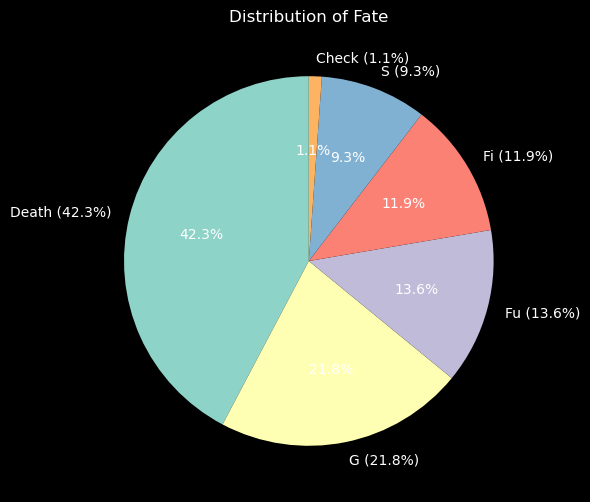

In [15]:
### 統計每個Fate的比例

import pandas as pd
import matplotlib.pyplot as plt

# 假設我們有 Fate 結果檔案
input_path = r"D:\ArcGIS\Morpho_Spatial_Demography\data\K1a_T23SJT25_Fate_All.csv"
df = pd.read_csv(input_path)

# 統計 Fate 比例
fate_counts = df["Fate"].value_counts()
fate_percent = fate_counts / fate_counts.sum() * 100

# 繪製圓餅圖
plt.figure(figsize=(6, 6))
plt.pie(
    fate_counts,
    labels=[f"{f} ({p:.1f}%)" for f, p in zip(fate_counts.index, fate_percent)],
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Distribution of Fate")
plt.show()
